<a href="https://colab.research.google.com/github/juanFeRoz/prediccion-genero-canciones-con-letra/blob/main/prediccion-genero-canciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Download dataset
url = "https://github.com/juanFeRoz/prediccion-genero-canciones-con-letra/raw/refs/heads/main/english_cleaned_lyrics.zip"
!wget $url
!unzip english_cleaned_lyrics.zip

--2024-12-09 22:10:27--  https://github.com/juanFeRoz/prediccion-genero-canciones-con-letra/raw/refs/heads/main/english_cleaned_lyrics.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juanFeRoz/prediccion-genero-canciones-con-letra/refs/heads/main/english_cleaned_lyrics.zip [following]
--2024-12-09 22:10:27--  https://raw.githubusercontent.com/juanFeRoz/prediccion-genero-canciones-con-letra/refs/heads/main/english_cleaned_lyrics.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76263793 (73M) [application/zip]
Saving to: ‘english_cleaned_lyrics.zip.1’

english_cleaned_lyr 100%[=============

In [3]:
#@title **Load libs** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
sns.set_theme()
pd.__version__

'2.2.2'

In [4]:
#@title **Load datasets** { display-mode: "form" }
dataset = "english_cleaned_lyrics.csv"
songs = pd.read_csv(dataset)

In [5]:
#@title **Preprocessing**

songs.dropna(inplace=True)
songs.loc[:, 'lyrics'] = songs.lyrics.apply(lambda x: str.lower(x))

def remove_whitespace(text):
    return  " ".join(str.split(text))

songs.loc[:, 'lyrics'] = songs.lyrics.apply(lambda x : remove_whitespace(x))



In [6]:
songs = songs[['lyrics', 'genre']]
songs.head()

,lyrics,genre
0,oh baby how you doing you know i'm gonna cut r...,Pop
1,playin everything so easy it's like you seem s...,Pop
2,if you search for tenderness it isn't hard to ...,Pop
3,oh oh oh i oh oh oh i if i wrote a book about ...,Pop
4,party the people the people the party it's pop...,Pop


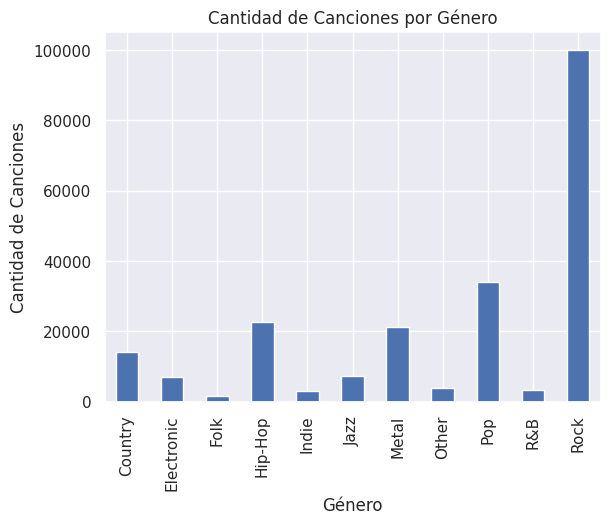

In [7]:
#songs = songs.sample(frac=0.5)
songs.groupby('genre').size().plot(kind='bar')
plt.xlabel("Género")
plt.ylabel("Cantidad de Canciones")
plt.title("Cantidad de Canciones por Género")
plt.show()

34137


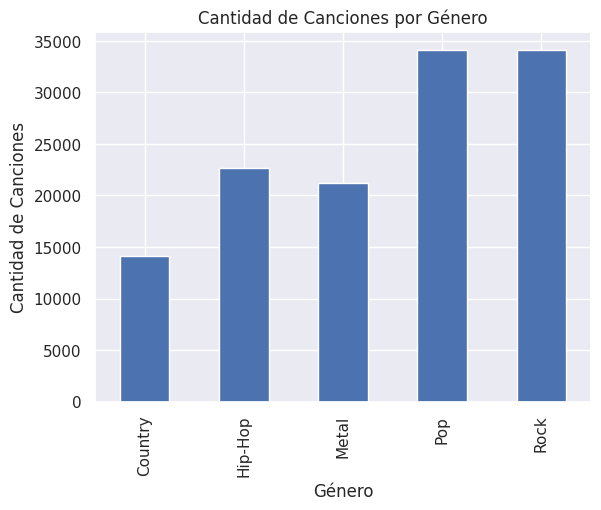

In [8]:
#@title Bajarle a rock
# como de rock hay deamsiadas canciones se genera un desbalance entonces hay que limitar la cantidad de canciones de este género
onlyrock = songs[songs.genre == 'Rock']
poplen = songs[songs.genre == 'Pop'].shape[0]
print(poplen)
onlyrock = onlyrock.sample(n=poplen)
songs = songs[songs.genre.isin(['Pop', 'Hip-Hop', 'Country', 'Metal'])]
songs = pd.concat([songs, onlyrock])
songs = songs.sample(frac=1)

songs.groupby('genre').size().plot(kind='bar')
plt.xlabel("Género")
plt.ylabel("Cantidad de Canciones")
plt.title("Cantidad de Canciones por Género")
plt.show()


plt.show()

In [9]:
#@title Bajarle a todos
#onlyrock = songs[songs.genre == 'Rock']
#onlypop = songs[songs.genre == 'Pop']
#onlyhiphop = songs[songs.genre == 'Hip-Hop']
#onlycountry = songs[songs.genre == 'Country']
#onlymetal = songs[songs.genre == 'Metal']
#
#countrylen = songs[songs.genre == 'Country'].shape[0]
#
#onlyrock = onlyrock.sample(n=countrylen)
#onlypop = onlypop.sample(n=countrylen)
#onlyhiphop = onlyhiphop.sample(n=countrylen)
#onlymetal = onlymetal.sample(n=countrylen)
#
#songs = songs[songs.genre.isin([])]
#songs = pd.concat([songs, onlycountry , onlyrock, onlypop, onlyhiphop, onlymetal])
#songs.head()

In [10]:
songs = songs.replace({'Hip-Hop': 1, 'Pop': 2, 'Country': 3, 'Metal': 4 , 'Rock': 5})
songs.head()

<ipython-input-10-1c0c33eb1189>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  songs = songs.replace({'Hip-Hop': 1, 'Pop': 2, 'Country': 3, 'Metal': 4 , 'Rock': 5})


,lyrics,genre
81915,pour a cup for the bitches that ain't scared t...,1
119301,i am such a lonely boy looking for someone to ...,2
59868,hey the first time that i met my mate was in t...,1
171272,take heart attacks without cracking a smile an...,4
125128,fear tomorrow's adversary and the wealth of up...,4


In [11]:
#@title Train test split
from sklearn.model_selection import train_test_split

songs = songs.sample(frac=1, random_state=21)

X = songs.lyrics
y = songs.genre

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

X_train.head()

,lyrics
163433,you want the guilty to be punished you want to...
116487,c w mccall bill fries chip davis one night las...
8911,i pray for peace they require me to kick into ...
124763,i believed in me young blood coursed in my vei...
172611,bow wow bently gt on the highway insane switch...


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(songs.lyrics)
len(vectorizer.vocabulary_)


153552

# **Extracting features from text files**
In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.
# Bags of words
The most intuitive way to do so is to use a bags of words representation:


1.   Assign a fixed integer id to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

2.   For each document **i**, count the number of occurrences of each word **w** and store it in **X[i, j]** as the value of feature **j** where **j** is the index of word **w** in the dictionary.



#From occurrences to frequencies

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”

In [13]:
#@title Building a pipeline for the model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

lyrics_clasifier_SGDC = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=21,
                           max_iter=5, tol=None)),
])

lyrics_clasifier_SGDC.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=21,
                               tol=None))])

In [14]:
from sklearn.naive_bayes import MultinomialNB


lyrics_clasifier_MNB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

lyrics_clasifier_MNB.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [15]:
from sklearn.naive_bayes import BernoulliNB
lyrics_clasifier_BNB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB()),
])

lyrics_clasifier_BNB.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', BernoulliNB())])

In [16]:
# from sklearn.svm import SVC

# lyrics_clasifier_SVC = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', SVC(kernel='linear')),
# ])

# lyrics_clasifier_SVC.fit(X_train, y_train)

In [17]:
from sklearn.linear_model import LogisticRegression

lyrics_clasifier_LR = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver="liblinear", multi_class="ovr")),
])

lyrics_clasifier_LR.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(multi_class='ovr', solver='liblinear'))])

In [18]:
# from sklearn.tree import DecisionTreeClassifier

# lyrics_clasifier_DTC = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
#     ('clf', DecisionTreeClassifier()),
# ])

# lyrics_clasifier_DTC.fit(X_train, y_train)

In [19]:
#@title Training the model
from sklearn.metrics import accuracy_score

y_pred_SGDC = lyrics_clasifier_SGDC.predict(X_test)
y_pred_MNB = lyrics_clasifier_MNB.predict(X_test)
y_pred_BNB = lyrics_clasifier_BNB.predict(X_test)
y_pred_LR = lyrics_clasifier_LR.predict(X_test)

uccs = []

uccs.append(accuracy_score(y_test, y_pred_SGDC))
uccs.append(accuracy_score(y_test, y_pred_MNB))
uccs.append(accuracy_score(y_test, y_pred_BNB))
uccs.append(accuracy_score(y_test, y_pred_LR))
print(uccs)

[0.5447755285175117, 0.5605056876666051, 0.6050568766660508, 0.6317136899891789]


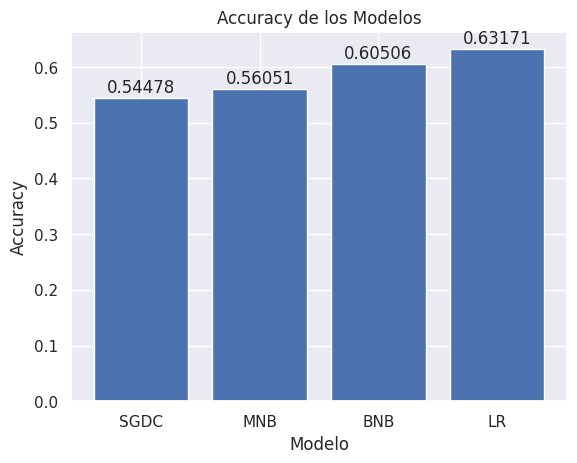

In [20]:
import matplotlib.pyplot as plt

modelos = ['SGDC', 'MNB', 'BNB', 'LR']
plt.bar(modelos, uccs)
plt.xlabel("Modelo")
plt.ylabel("Accuracy")
plt.title("Accuracy de los Modelos")

# Agregar valores encima de las barras
for i, v in enumerate(uccs):
    plt.text(i, v + 0.01, f"{v:.5f}", ha='center')

plt.show()

In [21]:
X_train_vect = vectorizer.transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [22]:
from keras.models import Sequential
from keras import layers

input_dim = X_train_vect.shape[1] #Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.compile(loss='sparse_categorical_crossentropy',
    optimizer='adagrad',
    metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │       1,535,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,535,596 (5.86 MB)

 Trainable params: 1,535,596 (5.86 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(X_train_vect, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test_vect, y_test),
                    batch_size=528)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 123s 733ms/step - accuracy: 0.3831 - loss: 1.4886 - val_accuracy: 0.4815 - val_loss: 1.3601
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.4903 - loss: 1.3363 - val_accuracy: 0.5060 - val_loss: 1.2920
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 85s 490ms/step - accuracy: 0.5117 - loss: 1.2762 - val_accuracy: 0.5197 - val_loss: 1.2511
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 142s 490ms/step - accuracy: 0.5263 - loss: 1.2384 - val_accuracy: 0.5296 - val_loss: 1.2229
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 138s 465ms/step - accuracy: 0.5364 - loss: 1.2128 - val_accuracy: 0.5370 - val_loss: 1.2015
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 82s 490ms/step - accuracy: 0.5429 - loss: 1.1882 - val_accuracy: 0.5438 - val_loss: 1.1847
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 135s 452ms/step - accuracy: 0.5483 - loss: 1.1766 - val_accuracy: 0.5500 - val_loss: 1.1707
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 75s 411ms/step - accuracy: 0.5547 - los

In [ ]:
from keras.backend import clear_session
clear_session()

In [26]:
loss, accuracy = model.evaluate(X_test_vect, y_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

1185/1185 ━━━━━━━━━━━━━━━━━━━━ 327s 276ms/step - accuracy: 0.5576 - loss: 1.1506
Testing Accuracy:  0.5609


In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

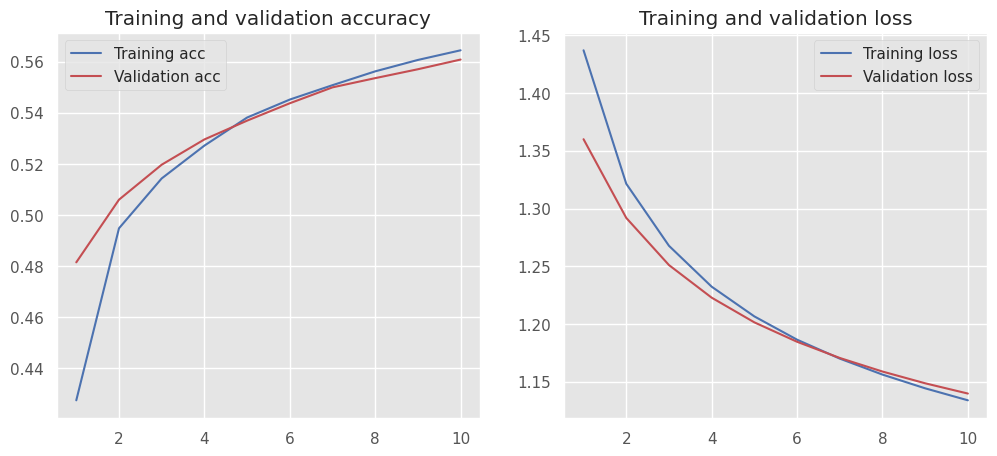

In [28]:
plot_history(history)